In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tqdm
import tensorflow as tf
import glob
import os
os.environ['CUDA_VISIBLE_DEVICES']=''

/home/deeplearning/anaconda2/envs/py27_tf/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
save_tfrecord_path = './tfrecord'

if not os.path.exists(save_tfrecord_path):
    os.mkdir(save_tfrecord_path)

In [3]:
path_list = glob.glob('/.dataset/*.jpg') #get images path
lable     = range(len(path_list))        #generate lables for test

In [5]:
image_num = len(path_list)              #the total number of pictures
image_num_per_tfrecord = 300            #each tfrecord file contains image_num_per_tfrecord images

In [6]:
def image_process(input_image):
    
    output_image = input_image
    output_image = output_image[:,:,::-1] #convert GBR to RGB
    return output_image

## Convert image to tfrecord

In [7]:
for index in tqdm.tqdm(xrange(image_num)):
    
    if index == 0:
        writer= tf.python_io.TFRecordWriter(save_tfrecord_path+'/'+"{}.tfrecords".format(index))
    elif index % image_num_per_tfrecord ==0:
        writer.close()
        writer= tf.python_io.TFRecordWriter(save_tfrecord_path+'/'+"{}.tfrecords".format(index))

    img=cv2.imread(path_list[index])
    img_raw = image_process(img).tostring()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[lable[index]])),
        'img_width':tf.train.Feature(int64_list=tf.train.Int64List(value=[img.shape[0]])),
        'img_height':tf.train.Feature(int64_list=tf.train.Int64List(value=[img.shape[1]])),
        
    })) 
    writer.write(example.SerializeToString())  
writer.close()   

100%|██████████| 2292/2292 [00:10<00:00, 217.69it/s]


## Read image from tfrecord and show 

In [8]:
feature = {  
    'img_raw': tf.FixedLenFeature([], tf.string),
    'img_width':tf.FixedLenFeature([], tf.int64),
    'img_height':tf.FixedLenFeature([], tf.int64),
    'label': tf.FixedLenFeature([], tf.int64)  
}

In [9]:
tfrecord_path_list = ['tfrecord/300.tfrecords']
filename_queue = tf.train.string_input_producer(tfrecord_path_list, num_epochs=1)  

reader = tf.TFRecordReader()  
_, serialized_example = reader.read(filename_queue)  

features = tf.parse_single_example(serialized_example, features=feature)  
image = tf.decode_raw(features['img_raw'], tf.uint8)  
label = tf.cast(features['label'], tf.int32)  
img_width = tf.cast(features['img_width'], tf.int32) 
img_height = tf.cast(features['img_height'], tf.int32) 
image = tf.reshape(image, [img_width, img_height, 3])  

In [12]:
sess = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())  
sess.run(init_op)  

In [ ]:
result_lable = []
result_image = []

In [13]:
coord = tf.train.Coordinator()  
threads = tf.train.start_queue_runners(sess=sess, coord=coord)  
for i in range(5):
    
    result_image.append(sess.run(image))    
    result_lable.append(sess.run(label)) 

coord.request_stop()  
coord.join(threads)  
sess.close()  

In [14]:
result_image[0].shape

(256, 256, 3)

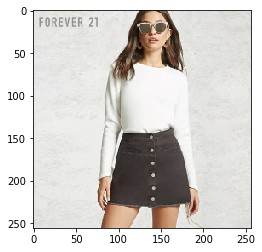

In [20]:
plt.imshow(result_image[3])

In [ ]:
result_lable[3]